In [1]:
import os.path
import mushr_rhc.defaults.parameters
import mushr_rhc.defaults.logger
import mushr_rhc.utils
import torch
import yaml
import pickle

push_data_collector = os.path.expanduser("~/catkin_ws/src/pixel_art/push_data_collector")
push_measures = os.path.expanduser("~/catkin_ws/src/pixel_art/push_data_collector/params/pusher_measures.yaml")
with open(push_measures, 'r') as f:
    push_measures_yaml = yaml.load(f)

K = 5
T = 40

params_dict = {
    "K" : K,
    "T": T,
    "horizon/time": .66,
    "npos": 6,
    "trajgen/desired_speed": 0.44,
    "x_gpr_file": "%s/x_gpr_jan_26.pickle" % push_data_collector,
    "y_gpr_file": "%s/y_gpr_jan_26.pickle" % push_data_collector,
    "theta_gpr_file": "%s/t_gpr_jan_26.pickle" % push_data_collector,
    "pushes_start_file": "%s/pushes_x.pickle" % push_data_collector,
    "pushes_file": "%s/pushes_y.pickle" % push_data_collector,
}

params_dict.update(push_measures_yaml)

params = mushr_rhc.defaults.parameters.DictParams(params_dict)

with open(params.get_str("x_gpr_file"), "rb") as f:
    x_gpr = pickle.load(f)

with open(params.get_str("y_gpr_file"), "rb") as f:
    y_gpr = pickle.load(f)

with open(params.get_str("theta_gpr_file"), "rb") as f:
    t_gpr = pickle.load(f)

In [2]:
import mushr_rhc.trajgen
import mushr_rhc.model

logger = mushr_rhc.defaults.logger.StdLog()

gpr = mushr_rhc.model.GPR(params, logger, torch.FloatTensor, gprs=(x_gpr, y_gpr, t_gpr))
traj_gen = mushr_rhc.trajgen.TL(params, logger, torch.FloatTensor)

---- XD:  0.29


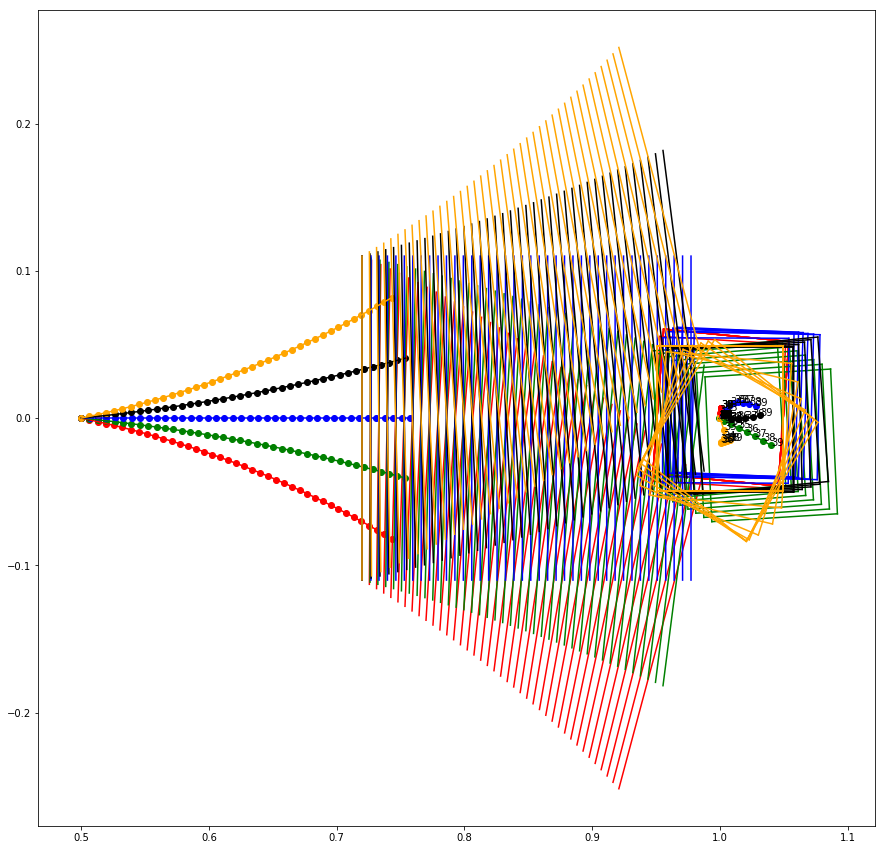

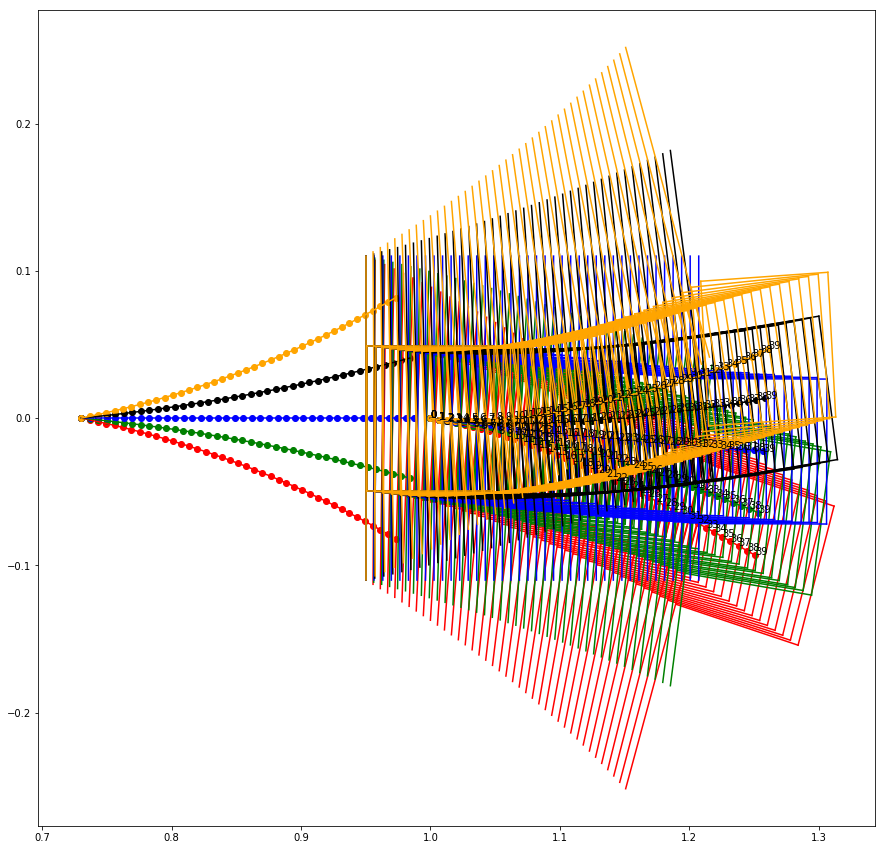

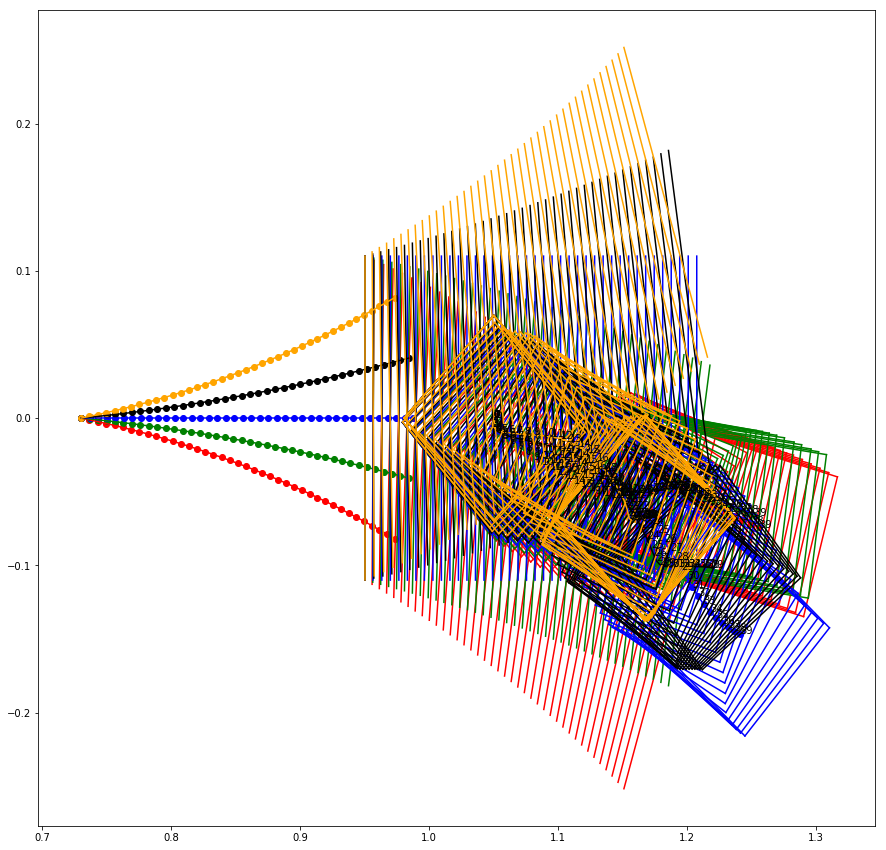

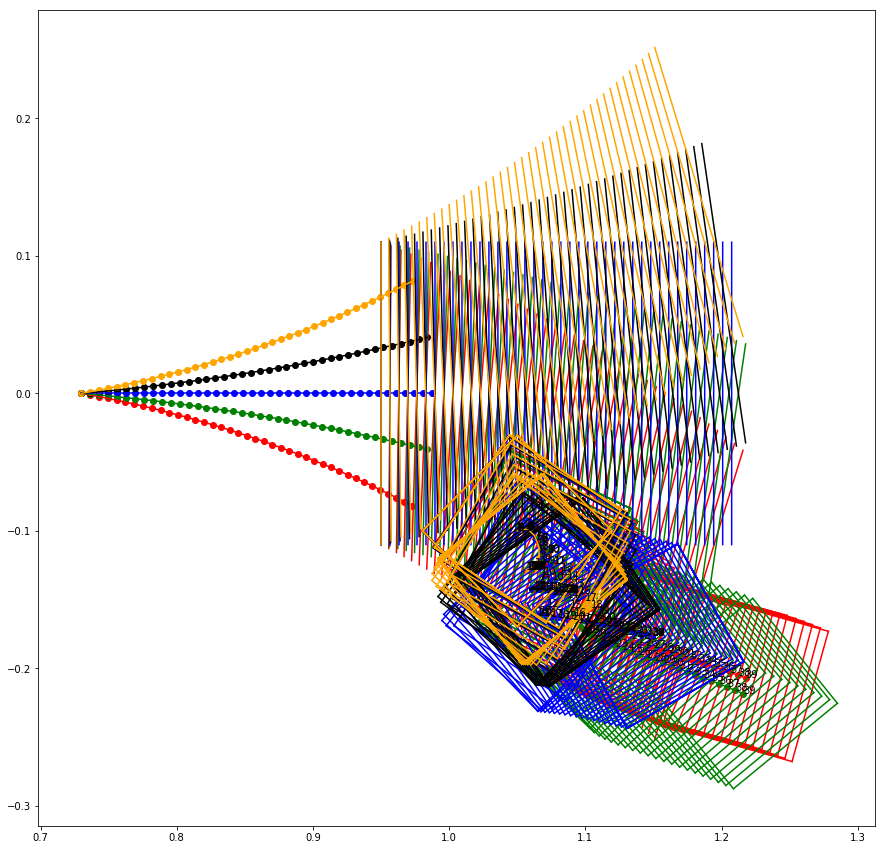

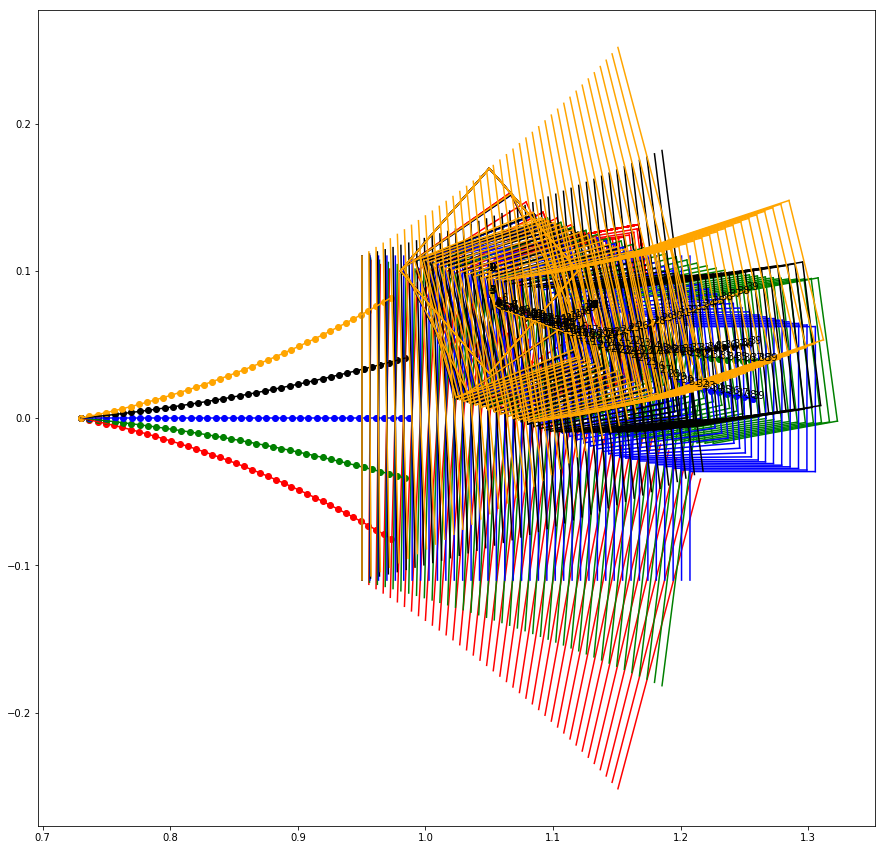

In [10]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

colors = ["red", "green", "blue", "black", "orange"]
arrows = True

def plot_block(x, y, theta, color):
    b= float(push_measures_yaml["block_side_len"]) / 2.0
    s, c = math.sin(theta), math.cos(theta)
    b1 = np.array([(c * -b) + (-s * -b) + x, (s * -b) + (c * -b) + y])
    b2 = np.array([(c * -b) + (-s * b) + x, (s * -b) + (c * b) + y])
    b3 = np.array([(c * b) + (-s * b) + x, (s * b) + (c * b) + y])
    b4 = np.array([(c * b) + (-s * -b) + x, (s * b) + (c * -b) + y])
    plt.plot([b1[0], b2[0]], [b1[1], b2[1]], color=color)
    plt.plot([b2[0], b3[0]], [b2[1], b3[1]], color=color)
    plt.plot([b3[0], b4[0]], [b3[1], b4[1]], color=color)
    plt.plot([b4[0], b1[0]], [b4[1], b1[1]], color=color)

def plot_pusher(car_x, car_y, car_theta, color):
    p_x = float(push_measures_yaml["x_pusher_pos"])
    p_y_top = float(push_measures_yaml["y_pusher_top"])
    p_y_bot = float(push_measures_yaml["y_pusher_bot"])
    s, c = math.sin(car_theta), math.cos(car_theta)
    b1 = np.array([(c * p_x) + (-s * p_y_bot) + car_x, (s * p_x) + (c * p_y_bot) + car_y])
    b2 = np.array([(c * p_x) + (-s * p_y_top) + car_x, (s * p_x) + (c * p_y_top) + car_y])
    plt.plot([b1[0], b2[0]], [b1[1], b2[1]], color=color)

xd = 0.29
test_poses = [
    torch.FloatTensor([0.0, 0.0, np.pi/2, -0.07, xd+.02, 0*math.pi/4]),
    torch.FloatTensor([0.0, 0.0, 0.0, xd, 0.1, math.pi/4]),
    torch.FloatTensor([0.0, 0.0, np.pi/6, 0.25, xd-0.05, math.pi/6]),
    torch.FloatTensor([0.0, 0.0, np.pi/6, xd-0.05, 0.25, math.pi/6]),
    torch.FloatTensor([0.0, 0.0, 0.0, xd-0.02, -0.13, math.pi/4]),
    torch.FloatTensor([0.0, 0.0, 0.0, xd-0.02, 0.13, math.pi/4]),
]

test_traj = [
    torch.FloatTensor([0.5, 0.0, 0.0, 1.0, 0.0, 0]),
    torch.FloatTensor([0.73, 0.0, 0.0, 1.0, 0.0, 0]),
    torch.FloatTensor([0.73, 0.0, 0.0, 1.05, 0.0, math.pi/4]),
    torch.FloatTensor([0.73, 0.0, 0.0, 1.05, -0.1, math.pi/4]),
    torch.FloatTensor([0.73, 0.0, 0.0, 1.05, 0.1, math.pi/4]),
]

#for xd in np.arange(0.29, .6, 0.08):
for xd in [0.29]:
    print "---- XD: ", xd
    t = traj_gen.get_control_trajectories(0.4)
    for pose in test_traj:

        rollouts = torch.FloatTensor(K, T, 6)

        gpr.rollout(pose, t, rollouts)

        plt.figure(figsize=(15,15))
        i = 0
        for r in rollouts:
            #plt.subplot(3, 2, i+1)
            plt.scatter(r[:, 0], r[:, 1], color=colors[i])

            plt.plot(r[:, 0], r[:, 1], color=colors[i])
            for p in r:
                plot_pusher(p[0], p[1], p[2], color=colors[i])

            #plt.scatter(rollouts[:, 0, 3], rollouts[:, 0, 4], color="red")

            if arrows:
                al = 0.005
                for p in r:
                    # print p[3], p[4], al * torch.cos(p[5]), al * torch.sin(p[5])
                    #plt.arrow(p[3], p[4], al * torch.cos(p[5]), al * torch.sin(p[5]), color="black", width=0.00005)
                    plot_block(p[3], p[4], p[5], colors[i])

            plt.scatter(r[:, 3], r[:, 4], color=colors[i])

            ax = plt.gca()

            for j in range(len(r)):
                ax.annotate(j, (r[j, 3], r[j, 4]))

            plt.plot(r[:, 3], r[:, 4], color=colors[i])
            i+=1
    plt.show()